In [1]:
from collections import OrderedDict
from pathlib import Path
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot(t, x):
    if x is None:
        plt.plot()
    else:
        t_plt = t[~x.isna()]
        x_plt = x[~x.isna()]
        plt.plot(t_plt, x_plt)


def plot_learning_curves(datasets: OrderedDict, name: str):
    plt.figure(figsize=(10, 7))

    for _, path in datasets.items():
        df = pd.read_csv(path / "progress.csv")
        plot(df.get("env_steps"), df.get("return"))

    plt.title(f"Learning Curve for {name}")
    plt.xlabel("env_steps")
    plt.ylabel("return")
    plt.legend(datasets.keys())
    plt.show()


def plot_loss_and_learning_curves(datasets: OrderedDict, name: str):
    n_items = len(datasets)
    c = 1

    plt.figure(figsize=(15, 10))

    for i, (name, path) in enumerate(datasets.items()):
        df = pd.read_csv(path / "progress.csv")
        with open(path / "flags.yml", "r") as f:
            cfg = yaml.load(f, Loader=yaml.SafeLoader)

        env_steps = df.get("env_steps")

        plt.subplot(3, n_items, i + 1)
        c += 1
        plot(env_steps, df["return"])
        plt.xlabel("env_steps")
        plt.ylabel("return")
        plt.title(f"Learning Curve for {name}")

        plt.subplot(3, n_items, n_items + i + 1)
        gamma = cfg.get("bisim_gamma")
        unscaled_transition_dist = df.get("transition_dist")
        if gamma is not None and unscaled_transition_dist is not None:
            transition_dist = gamma * unscaled_transition_dist
        else:
            transition_dist = None
        c += 1
        plot(env_steps, df.get("r_dist"))
        plot(env_steps, transition_dist)
        plt.xlabel("env_steps")
        plt.ylabel("bisim component")
        plt.title(f"Bisimulation Distance Components for {name}")
        plt.legend(["r_dist", "transition_dist"])

        plt.subplot(3, n_items, 2 * n_items + i + 1)
        bisimilarity = (
            None if transition_dist is None else df.get("r_dist") + transition_dist
        )
        c += 1
        plot(env_steps, df.get("z_dist"))
        plot(env_steps, bisimilarity)
        plt.xlabel("env_steps")
        plt.ylabel("loss component")
        plt.title(f"Bisimulation Loss Components for {name}")
        plt.legend(["z_dist", "bisimilarity"])

    plt.suptitle(f"Loss Components and Learning Curves for {name}", fontsize=16)
    plt.show()


def plot_encoder_signals(datasets: OrderedDict, name: str):
    n_items = len(datasets)
    plt.figure(figsize=(15, 10))

    for i, (dataset_name, dataset_path) in enumerate(datasets.items()):
        df = pd.read_csv(dataset_path / "progress.csv")

        env_steps = df.get("env_steps")

        plt.subplot(3, n_items, i + 1)
        plot(env_steps, df["alm_loss"])
        plot(env_steps, df["aux_loss"])
        plt.xlabel("env_steps")
        plt.ylabel("loss")
        plt.title(f"Total Encoder Loss for {dataset_name}")
        plt.legend(["alm_loss", "aux_loss"])

        plt.subplot(3, n_items, n_items + i + 1)
        plot(env_steps, df.get("bisim_critic_loss"))
        plt.xlabel("env_steps")
        plt.ylabel("loss")
        plt.title(f"Bisim Critic Loss for {dataset_name}")

        plt.subplot(3, n_items, 2 * n_items + i + 1)
        plot(env_steps, df["critic_loss"])
        plt.xlabel("env_steps")
        plt.ylabel("loss")
        plt.title(f"Agent Critic Loss for {dataset_name}")

    plt.suptitle(f"Encoder Signals for {name}", fontsize=16)
    plt.show()


def plot_combined_metrics(datasets: OrderedDict, name: str):
    n_items = len(datasets)
    plt.figure(figsize=(15, 20))  # Increased height to accommodate 4 rows

    for i, (dataset_name, dataset_path) in enumerate(datasets.items()):
        df = pd.read_csv(dataset_path / "progress.csv")
        with open(dataset_path / "flags.yml", "r") as f:
            cfg = yaml.load(f, Loader=yaml.SafeLoader)

        env_steps = df.get("env_steps")
        gamma = cfg.get("bisim_gamma")
        unscaled_transition_dist = df.get("transition_dist")
        if gamma is not None and unscaled_transition_dist is not None:
            transition_dist = gamma * unscaled_transition_dist
        else:
            transition_dist = None
        bisimilarity = (
            None if transition_dist is None else df.get("r_dist") + transition_dist
        )

        # 1) return
        plt.subplot(4, n_items, i + 1)
        plot(env_steps, df["return"])
        plt.xlabel("env_steps")
        plt.ylabel("return")
        plt.title(f"Learning Curve for {dataset_name}")

        # 2) alm_loss and aux_loss
        plt.subplot(4, n_items, n_items + i + 1)
        plot(env_steps, df["alm_loss"])
        plot(env_steps, df["aux_loss"])
        plt.xlabel("env_steps")
        plt.ylabel("loss")
        plt.title(f"Encoder Losses for {dataset_name}")
        plt.legend(["alm_loss", "aux_loss"])

        # 3) r_dist and transition_dist
        plt.subplot(4, n_items, 2 * n_items + i + 1)
        plot(env_steps, df.get("r_dist"))
        if transition_dist is not None:
            plot(env_steps, transition_dist)
        plt.xlabel("env_steps")
        plt.ylabel("distance")
        plt.title(f"Bisimulation Distance Components for {dataset_name}")
        plt.legend(["r_dist", "transition_dist"])

        # 4) z_dist and bisimilarity
        plt.subplot(4, n_items, 3 * n_items + i + 1)
        plot(env_steps, df.get("z_dist"))
        if bisimilarity is not None:
            plot(env_steps, bisimilarity)
        plt.xlabel("env_steps")
        plt.ylabel("distance/loss")
        plt.title(f"Bisimulation Loss Components for {dataset_name}")
        plt.legend(["z_dist", "bisimilarity"])

    plt.suptitle(f"Combined Metrics for {name}", fontsize=16)
    plt.tight_layout()
    plt.show()

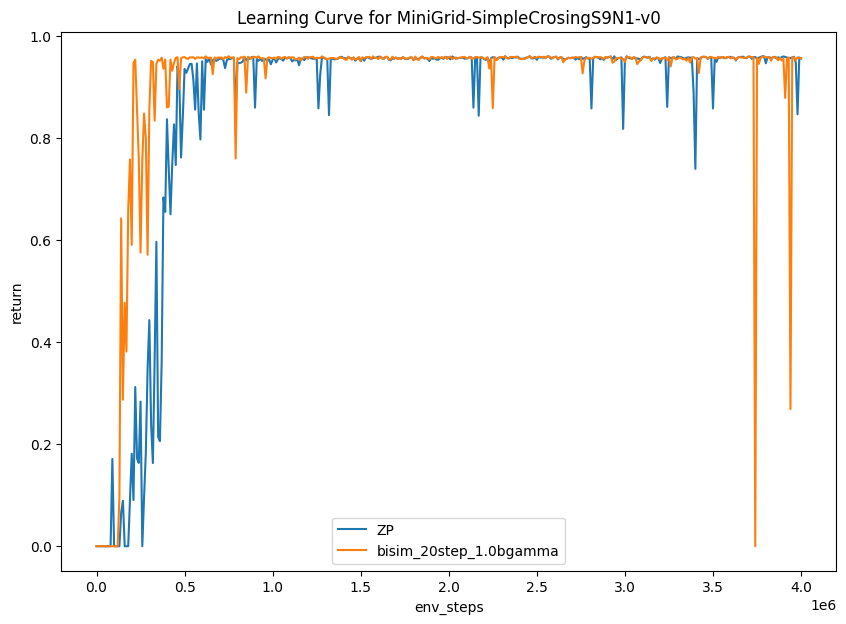

In [3]:
simple_s9n1_datasets = OrderedDict([
    ("ZP", Path("./logs/MiniGrid-SimpleCrossingS9N1-v0/2024-10-22-01:08:24_809784-809784/")),
    # ("bisim_1step_1.0bgamma", Path("./logs/MiniGrid-SimpleCrossingS9N1-v0/2024-10-22-19:51:54_3281532-3281532")),
    # ("bisim_10step_1.0bgamma_trial1", Path("./logs/MiniGrid-SimpleCrossingS9N1-v0/2024-10-22-19:48:09_3270747-3270747/")),
    # ("bisim_10step_1.0bgamma_trial2", Path("./logs/MiniGrid-SimpleCrossingS9N1-v0/2024-10-22-19:38:13_335832-335832/")), 
    ("bisim_20step_1.0bgamma", Path("./logs/MiniGrid-SimpleCrossingS9N1-v0/2024-10-22-19:51:19_3278504-3278504//")), 
])

plot_learning_curves(simple_s9n1_datasets, "MiniGrid-SimpleCrosingS9N1-v0")

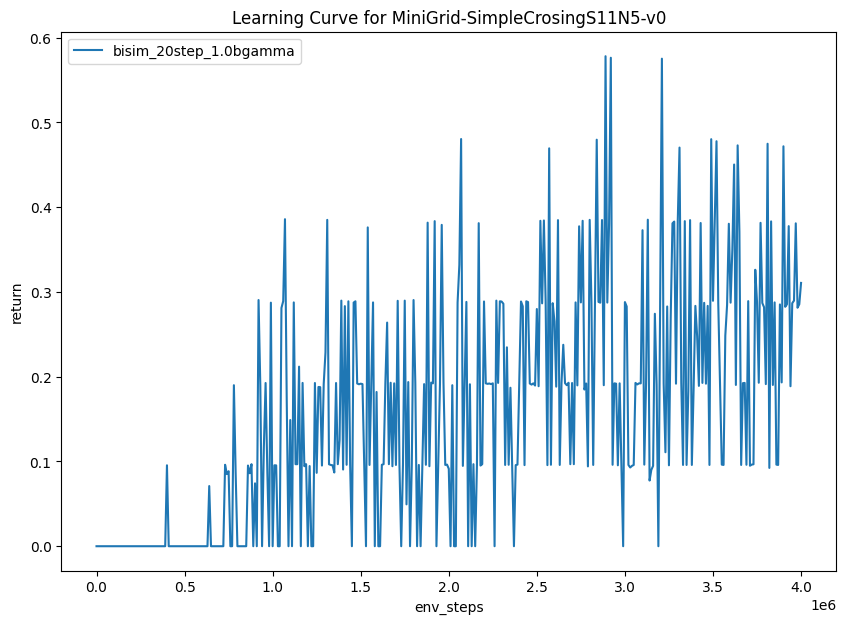

In [4]:
simple_s11n5_datasets = OrderedDict([
    ("bisim_20step_1.0bgamma", Path("./logs/MiniGrid-SimpleCrossingS11N5-v0/2024-10-23-01:15:33_1454368-1454368/")), 
])

plot_learning_curves(simple_s11n5_datasets, "MiniGrid-SimpleCrosingS11N5-v0")

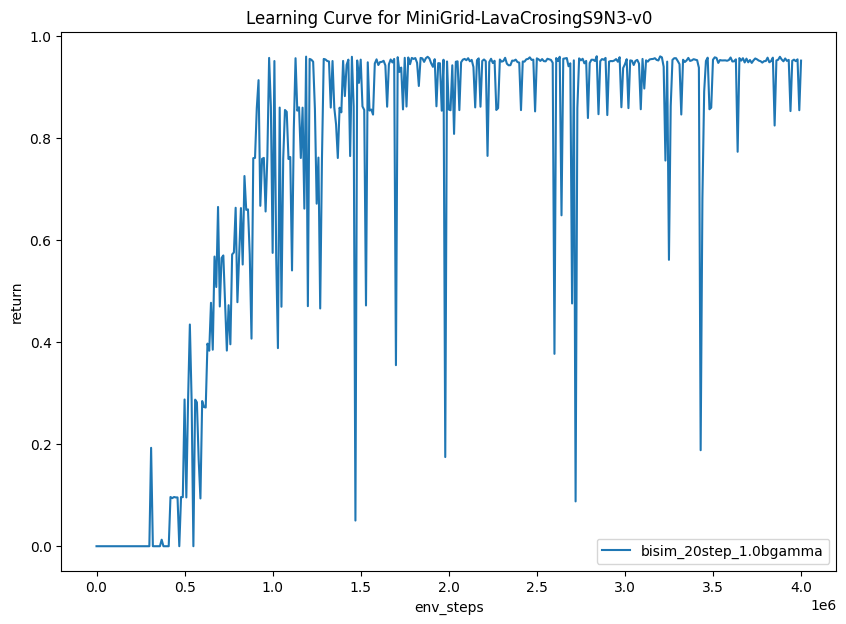

In [5]:
lava_s9n3_datasets = OrderedDict([
    ("bisim_20step_1.0bgamma", Path("./logs/MiniGrid-LavaCrossingS9N3-v0/2024-10-23-01:20:20_3736211-3736211/")), 
])

plot_learning_curves(lava_s9n3_datasets, "MiniGrid-LavaCrosingS9N3-v0")